In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from scipy.stats import norm
from scipy.stats import ttest_ind
import itertools

### **1. 데이터 불러오기**

- yahoo finance를 통해 글로벌 인덱스 지수의 종가 데이터 크롤링 하였음
- 기간 : 2023.01.01 ~ 2023.12.31 (1년치)
- 전처리 : 결측치는 drop과 backfill로 처리
- 최종 데이터 : 248 * 29


In [3]:

index = pd.read_csv('global_indices.csv')
index = index.iloc[:-10]

# 삭제하려는 컬럼 리스트
columns_to_drop = [
    'South Africa Top 40', 'Saudi Tadawul', 'Israel TA-125', 'Vietnam VN-Index', 'Philippine PSEi',
    'Colombia COLCAP', 'Chile IPSA', 'Peru S&P/BVL', 'Pakistan KSE 100', 'Bangladesh DSE General',
    'UAE ADX General', 'Qatar QE Index'
]

index = index.drop(columns=columns_to_drop, errors='ignore')

index = index.fillna(method='bfill')
index = index.iloc[:-1]
index

,Date,S&P 500,NASDAQ 100,Dow Jones,Russell 2000,MSCI World,Euro Stoxx 50,Nikkei 225,Shanghai Composite,FTSE 100,...,MOEX Russia,KLCI,TSEC Weighted Index,Straits Times,NZ 50,Argentina Merval,Mexican IPC,Turkey BIST 100,Thailand SET,Indonesia Jakarta Composite
0,2023-01-03 00:00:00,3824.139893,10862.639648,33136.371094,1750.729980,105.582092,3882.290039,25716.859375,3116.510010,7554.100098,...,2172.679932,1473.989990,14224.120117,3245.800049,11632.400391,198361.0,49050.460938,5626.600098,1678.969971,6888.757812
1,2023-01-04 00:00:00,3852.969971,10914.799805,33269.769531,1772.540039,106.617599,3973.969971,25716.859375,3123.520020,7585.200195,...,2168.419922,1469.550049,14199.129883,3242.459961,11632.400391,201061.0,50161.269531,5523.500000,1673.250000,6813.238770
2,2023-01-05 00:00:00,3808.100098,10741.219727,32930.078125,1753.189941,105.369186,3959.479980,25820.800781,3155.219971,7633.500000,...,2156.669922,1480.930054,14301.049805,3292.659912,11677.200195,209646.0,50805.210938,5116.399902,1663.859985,6653.840820
3,2023-01-06 00:00:00,3895.080078,11040.349609,33630.609375,1792.800049,107.856316,4017.830078,25973.849609,3157.639893,7699.500000,...,2156.389893,1480.550049,14373.339844,3276.719971,11625.969727,213794.0,51730.500000,5342.000000,1673.859985,6684.558105
4,2023-01-09 00:00:00,3892.090088,11108.450195,33517.648438,1795.910034,107.982124,4068.620117,26175.560547,3176.080078,7724.899902,...,2163.500000,1493.420044,14752.209961,3305.669922,11650.410156,215725.0,52280.050781,5171.000000,1691.119995,6688.265137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-12-21 00:00:00,4746.750000,16757.410156,37404.351562,2017.060059,130.199417,4524.859863,33140.468750,2918.715088,7694.700195,...,3073.570068,1455.579956,17543.740234,3112.500000,11601.259766,942904.0,57487.699219,7765.000000,1404.839966,7209.619141
245,2023-12-22 00:00:00,4754.629883,16777.400391,37385.968750,2033.959961,130.465393,4521.470215,33169.050781,2914.774902,7697.500000,...,3092.580078,1454.380005,17596.630859,3140.320068,11634.429688,948474.0,57313.468750,7557.600098,1405.089966,7237.519043
246,2023-12-26 00:00:00,4774.750000,16878.460938,37545.328125,2059.189941,131.007248,4528.379883,33305.851562,2898.879883,7725.000000,...,3094.719971,1450.780029,17751.730469,3139.979980,11687.969727,913125.0,57745.789062,7299.299805,1413.449951,7245.916016
247,2023-12-27 00:00:00,4781.580078,16906.800781,37656.519531,2066.209961,131.381622,4528.379883,33681.238281,2914.614014,7725.000000,...,3097.489990,1454.219971,17891.500000,3170.760010,11687.969727,872972.0,57554.468750,7260.399902,1410.430054,7245.916016


### **2. 수익률 데이터로 변환**

- 종가 데이터를 1일 수익률 데이터로 변환

In [4]:
# 날짜를 인덱스에서 칼럼으로 변환
prices = index.copy()
prices = prices.set_index('Date')

# 숫자로 변환
prices = prices.apply(pd.to_numeric, errors='coerce')

prices = prices.reset_index()
prices['Date'] = pd.to_datetime(prices['Date']).dt.strftime('%Y-%m-%d')

returns = prices.set_index('Date').pct_change().reset_index()

returns = returns.dropna()
returns.set_index('Date', inplace = True)
returns


,S&P 500,NASDAQ 100,Dow Jones,Russell 2000,MSCI World,Euro Stoxx 50,Nikkei 225,Shanghai Composite,FTSE 100,DAX,...,MOEX Russia,KLCI,TSEC Weighted Index,Straits Times,NZ 50,Argentina Merval,Mexican IPC,Turkey BIST 100,Thailand SET,Indonesia Jakarta Composite
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007539,0.004802,0.004026,0.012458,0.009808,0.023615,0.000000,0.002249,0.004117,0.021796,...,-0.001961,-0.003012,-0.001757,-0.001029,0.000000,0.013612,0.022646,-0.018324,-0.003407,-0.010963
2023-01-05,-0.011646,-0.015903,-0.010210,-0.010917,-0.011709,-0.003646,0.004042,0.010149,0.006368,-0.003759,...,-0.005419,0.007744,0.007178,0.015482,0.003851,0.042698,0.012837,-0.073703,-0.005612,-0.023395
2023-01-06,0.022841,0.027849,0.021273,0.022593,0.023604,0.014737,0.005927,0.000767,0.008646,0.012033,...,-0.000130,-0.000257,0.005055,-0.004841,-0.004387,0.019786,0.018212,0.044094,0.006010,0.004616
2023-01-09,-0.000768,0.006168,-0.003359,0.001735,0.001166,0.012641,0.007766,0.005840,0.003299,0.012513,...,0.003297,0.008693,0.026359,0.008835,0.002102,0.009032,0.010623,-0.032010,0.010312,0.000555
2023-01-10,0.006978,0.008762,0.005563,0.014889,0.005467,-0.002743,0.000000,-0.002069,-0.003935,-0.001232,...,-0.001844,-0.005551,0.003440,-0.012935,0.000518,0.000399,0.001224,-0.035390,0.000172,-0.009833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.010301,0.012278,0.008693,0.017258,0.011713,-0.001976,-0.015901,0.005722,-0.002722,-0.002727,...,-0.010014,-0.006132,-0.005186,0.001438,0.002613,0.024995,0.010162,0.013324,0.003192,-0.001392
2023-12-22,0.001660,0.001193,-0.000491,0.008378,0.002043,-0.000749,0.000862,-0.001350,0.000364,0.001124,...,0.006185,-0.000824,0.003015,0.008938,0.002859,0.005907,-0.003031,-0.026710,0.000178,0.003870
2023-12-26,0.004232,0.006024,0.004263,0.012404,0.004153,0.001528,0.004124,-0.005453,0.003573,0.002148,...,0.000692,-0.002475,0.008814,-0.000108,0.004602,-0.037269,0.007543,-0.034178,0.005950,0.001160


### **3. 각 지수를 노드로, 지수간 상관관계를 엣지로 설정**

- 상관관계를 계산해서 절댓값이 0.3 이상인 것들에 대해서만 노드와 엣지로 구성
- 총 노드 수 : 26, 엣지 수 : 216

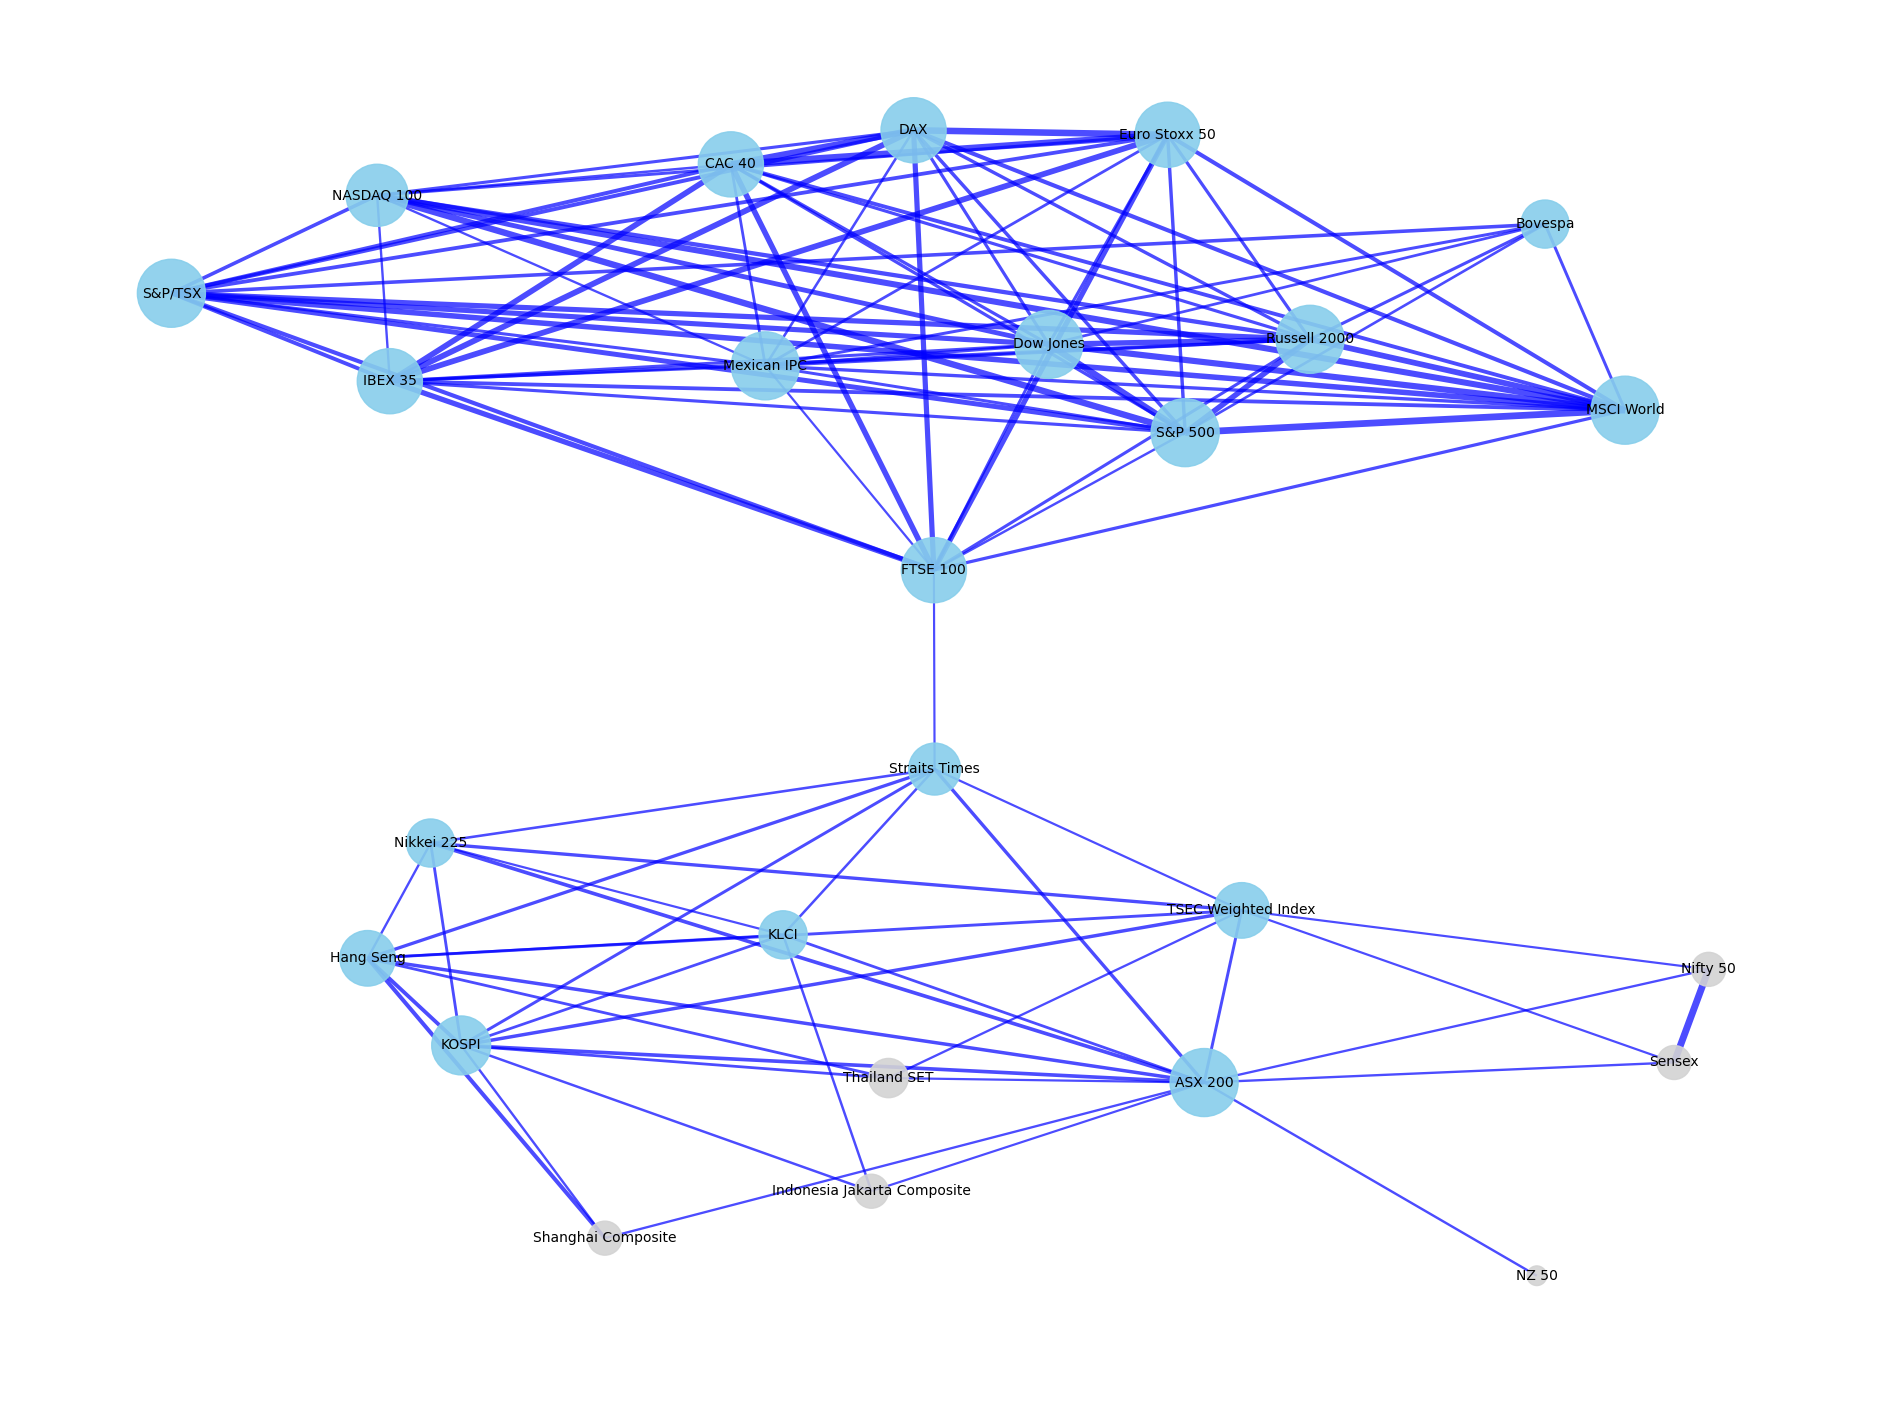

In [25]:

correlation_matrix = returns.corr()
G = nx.Graph()

for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j:
            weight = correlation_matrix.loc[i, j]
            if abs(weight) > 0.3:  # correlation threshold
                G.add_edge(i, j, weight=weight)


# 개선된 그래프 시각화
plt.figure(figsize=(24, 18))

pos = nx.kamada_kawai_layout(G)

weights = nx.get_edge_attributes(G, 'weight')
edge_colors = ['blue' if w > 0 else 'red' for w in weights.values()]
edge_widths = [abs(w) * 5 for w in weights.values()]  # 상관계수에 비례

node_sizes = [len(list(G.neighbors(node))) * 200 for node in G.nodes()]

node_colors = ['skyblue' if len(list(G.neighbors(node))) > 5 else 'lightgray' for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, edgelist=weights.keys(), edge_color=edge_colors, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

#plt.title("Enhanced Spillover Effect Graph", fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()


In [5]:
returns

,S&P 500,NASDAQ 100,Dow Jones,Russell 2000,MSCI World,Euro Stoxx 50,Nikkei 225,Shanghai Composite,FTSE 100,DAX,...,MOEX Russia,KLCI,TSEC Weighted Index,Straits Times,NZ 50,Argentina Merval,Mexican IPC,Turkey BIST 100,Thailand SET,Indonesia Jakarta Composite
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007539,0.004802,0.004026,0.012458,0.009808,0.023615,0.000000,0.002249,0.004117,0.021796,...,-0.001961,-0.003012,-0.001757,-0.001029,0.000000,0.013612,0.022646,-0.018324,-0.003407,-0.010963
2023-01-05,-0.011646,-0.015903,-0.010210,-0.010917,-0.011709,-0.003646,0.004042,0.010149,0.006368,-0.003759,...,-0.005419,0.007744,0.007178,0.015482,0.003851,0.042698,0.012837,-0.073703,-0.005612,-0.023395
2023-01-06,0.022841,0.027849,0.021273,0.022593,0.023604,0.014737,0.005927,0.000767,0.008646,0.012033,...,-0.000130,-0.000257,0.005055,-0.004841,-0.004387,0.019786,0.018212,0.044094,0.006010,0.004616
2023-01-09,-0.000768,0.006168,-0.003359,0.001735,0.001166,0.012641,0.007766,0.005840,0.003299,0.012513,...,0.003297,0.008693,0.026359,0.008835,0.002102,0.009032,0.010623,-0.032010,0.010312,0.000555
2023-01-10,0.006978,0.008762,0.005563,0.014889,0.005467,-0.002743,0.000000,-0.002069,-0.003935,-0.001232,...,-0.001844,-0.005551,0.003440,-0.012935,0.000518,0.000399,0.001224,-0.035390,0.000172,-0.009833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.010301,0.012278,0.008693,0.017258,0.011713,-0.001976,-0.015901,0.005722,-0.002722,-0.002727,...,-0.010014,-0.006132,-0.005186,0.001438,0.002613,0.024995,0.010162,0.013324,0.003192,-0.001392
2023-12-22,0.001660,0.001193,-0.000491,0.008378,0.002043,-0.000749,0.000862,-0.001350,0.000364,0.001124,...,0.006185,-0.000824,0.003015,0.008938,0.002859,0.005907,-0.003031,-0.026710,0.000178,0.003870
2023-12-26,0.004232,0.006024,0.004263,0.012404,0.004153,0.001528,0.004124,-0.005453,0.003573,0.002148,...,0.000692,-0.002475,0.008814,-0.000108,0.004602,-0.037269,0.007543,-0.034178,0.005950,0.001160


### **4. 기본 데이터를 Tabular Form으로 활용했을 때 성능 평가**

#### 4.1 Random Forest Model 사용

In [9]:
# 노드 추출
nodes_in_graph = list(G.nodes)
print(f"Selected nodes: {nodes_in_graph}")

# **Step 2: 노드에 해당하는 지수 데이터 필터링**
filtered_returns = returns[nodes_in_graph]
X = filtered_returns.dropna().values  # 필터링된 수익률 데이터
n_indices = X.shape[1]  # 열의 개수 (26개)
n_timesteps = X.shape[0]  # 시점 개수

# 열 이름 (실제 지수 이름) 가져오기
index_names = filtered_returns.columns.tolist()

# **Step 3: 반복 실험 (Random Forest 사용)**
n_experiments = 100  # 각 열(i)에 대해 100번 반복
results = []

for target_idx in range(n_indices):  # 각 열(i)마다 반복
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(n_experiments):  # 100번 반복
        # 독립 변수(X)와 종속 변수(y) 설정
        X_feature = X[:-1, :]  # 1~(n_timesteps-1)행까지 (t 시점)
        y_target = (X[1:, target_idx] > 0).astype(int)  # 2~n_timesteps행까지 (t+1 시점의 target_idx 열)

        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=11)

        # 랜덤 포레스트 모델 학습
        clf = RandomForestClassifier(n_estimators=100, random_state=11)
        clf.fit(X_train, y_train)

        # 예측 및 평가 (Test 데이터에서만 수행)
        y_pred = clf.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)  # Balanced Accuracy
        f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 Score
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Confusion Matrix 계산 (TT, TF, FT, FF)

        # 결과 저장
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # 평균 및 confusion matrix 합산
    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)  # Confusion Matrix 누적

    # 결과를 행 단위로 저장
    results.append({
        'Target Index': index_names[target_idx],  # 실제 지수 이름 추가
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# **Step 4: 결과를 데이터프레임으로 변환**
results_df_rf_26 = pd.DataFrame(results)

# 결과 출력
results_df_rf_26


Selected nodes: ['S&P 500', 'NASDAQ 100', 'Dow Jones', 'Russell 2000', 'MSCI World', 'Euro Stoxx 50', 'FTSE 100', 'DAX', 'CAC 40', 'S&P/TSX', 'Bovespa', 'IBEX 35', 'Mexican IPC', 'Nikkei 225', 'Hang Seng', 'KOSPI', 'ASX 200', 'KLCI', 'TSEC Weighted Index', 'Straits Times', 'Shanghai Composite', 'Thailand SET', 'Indonesia Jakarta Composite', 'Sensex', 'Nifty 50', 'NZ 50']


,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,2200,600,1600,600,0.529221,0.509804
1,NASDAQ 100,2400,500,1700,400,0.509031,0.476190
2,Dow Jones,2400,700,1100,800,0.597623,0.598930
3,Russell 2000,1700,1300,900,1100,0.558333,0.553571
4,MSCI World,2100,800,1500,600,0.504926,0.494505
5,Euro Stoxx 50,1600,1100,1600,700,0.448470,0.441918
6,FTSE 100,1600,1000,1300,1100,0.536859,0.535354
7,DAX,1500,900,1900,700,0.447115,0.425287
8,CAC 40,1600,900,1500,1000,0.520000,0.512987
9,S&P/TSX,2100,500,1500,900,0.591346,0.575552


#### 4.2 Gradient Boost Classifier (XGBoost) Model 사용

In [10]:
# **Step 1: 노드 추출**
nodes_in_graph = list(G.nodes)
print(f"Selected nodes: {nodes_in_graph}")

# **Step 2: 노드에 해당하는 지수 데이터 필터링**
filtered_returns = returns[nodes_in_graph]
X = filtered_returns.dropna().values  # 필터링된 수익률 데이터
n_indices = X.shape[1]  # 열의 개수 (26개)
n_timesteps = X.shape[0]  # 시점 개수

# 열 이름 (실제 지수 이름) 가져오기
index_names = filtered_returns.columns.tolist()

# **Step 3: 반복 실험 (Gradient Boosting Classifier 사용)**
n_experiments = 100  # 각 열(i)에 대해 100번 반복
results = []

for target_idx in range(n_indices):  # 각 열(i)마다 반복
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(n_experiments):  # 100번 반복
        # 독립 변수(X)와 종속 변수(y) 설정
        X_feature = X[:-1, :]  # 1~(n_timesteps-1)행까지 (t 시점)
        y_target = (X[1:, target_idx] > 0).astype(int)  # 2~n_timesteps행까지 (t+1 시점의 target_idx 열)

        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=11)

        # Gradient Boosting Classifier 모델 학습
        clf = GradientBoostingClassifier(random_state=11)
        clf.fit(X_train, y_train)

        # 예측 및 평가 (Test 데이터에서만 수행)
        y_pred = clf.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)  # Balanced Accuracy
        f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 Score
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Confusion Matrix 계산 (TT, TF, FT, FF)

        # 결과 저장
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # 평균 및 confusion matrix 합산
    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)  # Confusion Matrix 누적

    # 결과를 행 단위로 저장
    results.append({
        'Target Index': index_names[target_idx],  # 실제 지수 이름 추가
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# **Step 4: 결과를 데이터프레임으로 변환**
results_df_gbc_26 = pd.DataFrame(results)

# 결과 출력
results_df_gbc_26


Selected nodes: ['S&P 500', 'NASDAQ 100', 'Dow Jones', 'Russell 2000', 'MSCI World', 'Euro Stoxx 50', 'FTSE 100', 'DAX', 'CAC 40', 'S&P/TSX', 'Bovespa', 'IBEX 35', 'Mexican IPC', 'Nikkei 225', 'Hang Seng', 'KOSPI', 'ASX 200', 'KLCI', 'TSEC Weighted Index', 'Straits Times', 'Shanghai Composite', 'Thailand SET', 'Indonesia Jakarta Composite', 'Sensex', 'Nifty 50', 'NZ 50']


,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,2100,700,1100,1100,0.625000,0.625000
1,NASDAQ 100,1800,1100,1000,1100,0.572250,0.571603
2,Dow Jones,2200,900,1200,700,0.539049,0.538462
3,Russell 2000,1800,1200,1100,900,0.525000,0.524597
4,MSCI World,2000,900,1400,700,0.511494,0.506650
5,Euro Stoxx 50,1700,1000,1700,600,0.445250,0.432535
6,FTSE 100,1700,900,1800,600,0.451923,0.432535
7,DAX,2100,300,1800,800,0.591346,0.549550
8,CAC 40,1800,700,1600,900,0.540000,0.524597
9,S&P/TSX,2300,300,1600,800,0.608974,0.582418


#### 4.3. Multi-Layer Perceptron Model 사용

In [11]:
# **Step 1: 노드 추출**
nodes_in_graph = list(G.nodes)
print(f"Selected nodes: {nodes_in_graph}")

# **Step 2: 노드에 해당하는 지수 데이터 필터링**
filtered_returns = returns[nodes_in_graph]
X = filtered_returns.dropna().values  # 필터링된 수익률 데이터
n_indices = X.shape[1]  # 열의 개수 (26개)
n_timesteps = X.shape[0]  # 시점 개수

# 열 이름 (실제 지수 이름) 가져오기
index_names = filtered_returns.columns.tolist()

# **Step 3: 반복 실험 (Multi Layer Perceptron Classifier 사용)**
n_experiments = 100  # 각 열(i)에 대해 100번 반복
results = []

for target_idx in range(n_indices):  # 각 열(i)마다 반복
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(n_experiments):  # 100번 반복
        # 독립 변수(X)와 종속 변수(y) 설정
        X_feature = X[:-1, :]  # 1~(n_timesteps-1)행까지 (t 시점)
        y_target = (X[1:, target_idx] > 0).astype(int)  # 2~n_timesteps행까지 (t+1 시점의 target_idx 열)

        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=11)

        # Multi Layer Perceptron Classifier 모델 학습
        clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='tanh', random_state=11)
        clf.fit(X_train, y_train)

        # 예측 및 평가 (Test 데이터에서만 수행)
        y_pred = clf.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)  # Balanced Accuracy
        f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 Score
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Confusion Matrix 계산 (TT, TF, FT, FF)

        # 결과 저장
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # 평균 및 confusion matrix 합산
    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)  # Confusion Matrix 누적

    # 결과를 행 단위로 저장
    results.append({
        'Target Index': index_names[target_idx],  # 실제 지수 이름 추가
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# **Step 4: 결과를 데이터프레임으로 변환**
results_df_mlp_26 = pd.DataFrame(results)

# 결과 출력
results_df_mlp_26


Selected nodes: ['S&P 500', 'NASDAQ 100', 'Dow Jones', 'Russell 2000', 'MSCI World', 'Euro Stoxx 50', 'FTSE 100', 'DAX', 'CAC 40', 'S&P/TSX', 'Bovespa', 'IBEX 35', 'Mexican IPC', 'Nikkei 225', 'Hang Seng', 'KOSPI', 'ASX 200', 'KLCI', 'TSEC Weighted Index', 'Straits Times', 'Shanghai Composite', 'Thailand SET', 'Indonesia Jakarta Composite', 'Sensex', 'Nifty 50', 'NZ 50']


,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,2800,0,2200,0,0.500000,0.358974
1,NASDAQ 100,2900,0,2100,0,0.500000,0.367089
2,Dow Jones,2300,800,1400,500,0.502547,0.494485
3,Russell 2000,300,2700,300,1700,0.475000,0.348958
4,MSCI World,2900,0,2100,0,0.500000,0.367089
5,Euro Stoxx 50,2700,0,2300,0,0.500000,0.350649
6,FTSE 100,2500,100,2300,100,0.501603,0.376299
7,DAX,2400,0,2600,0,0.500000,0.324324
8,CAC 40,2500,0,2500,0,0.500000,0.333333
9,S&P/TSX,2300,300,2000,400,0.525641,0.462366


#### 4.4. K-Nearest Neighbors Model

In [12]:
# **Step 1: 노드 추출**
nodes_in_graph = list(G.nodes)
print(f"Selected nodes: {nodes_in_graph}")

# **Step 2: 노드에 해당하는 지수 데이터 필터링**
filtered_returns = returns[nodes_in_graph]
X = filtered_returns.dropna().values  # 필터링된 수익률 데이터
n_indices = X.shape[1]  # 열의 개수 (26개)
n_timesteps = X.shape[0]  # 시점 개수

# 열 이름 (실제 지수 이름) 가져오기
index_names = filtered_returns.columns.tolist()

# **Step 3: 반복 실험 (K-Nearest Neighbors Classifier 사용)**
n_experiments = 100  # 각 열(i)에 대해 100번 반복
results = []

for target_idx in range(n_indices):  # 각 열(i)마다 반복
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(n_experiments):  # 100번 반복
        # 독립 변수(X)와 종속 변수(y) 설정
        X_feature = X[:-1, :]  # 1~(n_timesteps-1)행까지 (t 시점)
        y_target = (X[1:, target_idx] > 0).astype(int)  # 2~n_timesteps행까지 (t+1 시점의 target_idx 열)

        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=11)

        # K-Nearest Neighbors Classifier 모델 학습
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train, y_train)

        # 예측 및 평가 (Test 데이터에서만 수행)
        y_pred = clf.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)  # Balanced Accuracy
        f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 Score
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Confusion Matrix 계산 (TT, TF, FT, FF)

        # 결과 저장
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # 평균 및 confusion matrix 합산
    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)  # Confusion Matrix 누적

    # 결과를 행 단위로 저장
    results.append({
        'Target Index': index_names[target_idx],  # 실제 지수 이름 추가
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# **Step 4: 결과를 데이터프레임으로 변환**
results_df_knn_26 = pd.DataFrame(results)

# 결과 출력
results_df_knn_26


Selected nodes: ['S&P 500', 'NASDAQ 100', 'Dow Jones', 'Russell 2000', 'MSCI World', 'Euro Stoxx 50', 'FTSE 100', 'DAX', 'CAC 40', 'S&P/TSX', 'Bovespa', 'IBEX 35', 'Mexican IPC', 'Nikkei 225', 'Hang Seng', 'KOSPI', 'ASX 200', 'KLCI', 'TSEC Weighted Index', 'Straits Times', 'Shanghai Composite', 'Thailand SET', 'Indonesia Jakarta Composite', 'Sensex', 'Nifty 50', 'NZ 50']


,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,2000,800,1700,500,0.470779,0.450549
1,NASDAQ 100,2000,900,1400,700,0.511494,0.506650
2,Dow Jones,2100,1000,1500,400,0.443973,0.434645
3,Russell 2000,1500,1500,1200,800,0.450000,0.449204
4,MSCI World,2100,800,1400,700,0.528736,0.522569
5,Euro Stoxx 50,2000,700,1600,700,0.522544,0.506650
6,FTSE 100,2000,600,1700,700,0.530449,0.506650
7,DAX,1900,500,1600,1000,0.588141,0.565936
8,CAC 40,2200,300,1900,600,0.560000,0.509804
9,S&P/TSX,1800,800,1500,900,0.533654,0.524597


#### 4.5. Support Vector Machine

In [13]:
# **Step 1: 노드 추출**
nodes_in_graph = list(G.nodes)
print(f"Selected nodes: {nodes_in_graph}")

# **Step 2: 노드에 해당하는 지수 데이터 필터링**
filtered_returns = returns[nodes_in_graph]
X = filtered_returns.dropna().values  # 필터링된 수익률 데이터
n_indices = X.shape[1]  # 열의 개수 (26개)
n_timesteps = X.shape[0]  # 시점 개수

# 열 이름 (실제 지수 이름) 가져오기
index_names = filtered_returns.columns.tolist()

# **Step 3: 반복 실험 (Support Vector Classifier 사용)**
n_experiments = 100  # 각 열(i)에 대해 100번 반복
results = []

for target_idx in range(n_indices):  # 각 열(i)마다 반복
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(n_experiments):  # 100번 반복
        # 독립 변수(X)와 종속 변수(y) 설정
        X_feature = X[:-1, :]  # 1~(n_timesteps-1)행까지 (t 시점)
        y_target = (X[1:, target_idx] > 0).astype(int)  # 2~n_timesteps행까지 (t+1 시점의 target_idx 열)

        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=11)

        # Support Vector Classifier 모델 학습
        clf = SVC(kernel='rbf', probability=True, random_state=11)
        clf.fit(X_train, y_train)

        # 예측 및 평가 (Test 데이터에서만 수행)
        y_pred = clf.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)  # Balanced Accuracy
        f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 Score
        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Confusion Matrix 계산 (TT, TF, FT, FF)

        # 결과 저장
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

    # 평균 및 confusion matrix 합산
    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)  # Confusion Matrix 누적

    # 결과를 행 단위로 저장
    results.append({
        'Target Index': index_names[target_idx],  # 실제 지수 이름 추가
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# **Step 4: 결과를 데이터프레임으로 변환**
results_df_svc_26 = pd.DataFrame(results)

# 결과 출력
results_df_svc_26


Selected nodes: ['S&P 500', 'NASDAQ 100', 'Dow Jones', 'Russell 2000', 'MSCI World', 'Euro Stoxx 50', 'FTSE 100', 'DAX', 'CAC 40', 'S&P/TSX', 'Bovespa', 'IBEX 35', 'Mexican IPC', 'Nikkei 225', 'Hang Seng', 'KOSPI', 'ASX 200', 'KLCI', 'TSEC Weighted Index', 'Straits Times', 'Shanghai Composite', 'Thailand SET', 'Indonesia Jakarta Composite', 'Sensex', 'Nifty 50', 'NZ 50']


,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,2600,200,2000,200,0.509740,0.428274
1,NASDAQ 100,2600,300,1700,400,0.543514,0.503968
2,Dow Jones,2400,700,1400,500,0.518676,0.509116
3,Russell 2000,1700,1300,800,1200,0.583333,0.575758
4,MSCI World,2500,400,1600,500,0.550082,0.523810
5,Euro Stoxx 50,2300,400,1600,700,0.578100,0.554367
6,FTSE 100,1900,700,1300,1100,0.594551,0.589491
7,DAX,2300,100,1900,700,0.613782,0.554367
8,CAC 40,2100,400,1800,700,0.560000,0.522569
9,S&P/TSX,1200,1400,1400,1000,0.439103,0.439103


### **5. 그래프 임베딩 후 성능 변화 관찰**

#### 5.1. GCN Model 임베딩

In [15]:
# GCN model definition
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim1, hidden_dim2, embedding_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(int(num_features), hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Prepare time-series data
def prepare_time_series_data(data_matrix):
    X = data_matrix.iloc[:-1].values
    y = data_matrix.iloc[1:].values
    return X, y

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Graph preprocessing
nodes_in_graph = list(G.nodes)
node_to_idx = {node: idx for idx, node in enumerate(nodes_in_graph)}
returns_subset = returns[nodes_in_graph]
X_full, y_full = prepare_time_series_data(returns_subset)

edge_index = torch.tensor(
    [[node_to_idx[edge[0]], node_to_idx[edge[1]]] for edge in G.edges],
    dtype=torch.long
).t()

# Hyperparameters
hidden_dim1_options = [16, 32, 64]
hidden_dim2_options = [16, 32, 64]
embedding_dim_options = [16, 32, 64]
lr = 0.01

# Initialize tuning results
tuning_results = []

# Iterate over hyperparameter combinations
for hidden_dim1, hidden_dim2, embedding_dim in itertools.product(hidden_dim1_options, hidden_dim2_options, embedding_dim_options):
    print(f"Testing: hidden_dim1={hidden_dim1}, hidden_dim2={hidden_dim2}, embedding_dim={embedding_dim}")

    accuracy_scores = []
    
    for target_idx in range(X_full.shape[1]):
        acc_for_target = []

        for _ in range(10):  # Repeat 10 times for each target
            X = X_full
            y = (y_full[:, target_idx] > 0).astype(int)

            data = Data(
                x=torch.tensor(X, dtype=torch.float32),
                y=torch.tensor(y, dtype=torch.long),
                edge_index=edge_index
            )

            model = GCN(num_features=X.shape[1], hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, embedding_dim=embedding_dim).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            model.train()
            for epoch in range(100):
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                y_pred = model(data).argmax(dim=1).cpu().numpy()
                y_true = data.y.cpu().numpy()
                acc = balanced_accuracy_score(y_true, y_pred)
                acc_for_target.append(acc)

        accuracy_scores.append(np.mean(acc_for_target))

    avg_accuracy = np.mean(accuracy_scores)
    tuning_results.append({
        'hidden_dim1': hidden_dim1,
        'hidden_dim2': hidden_dim2,
        'embedding_dim': embedding_dim,
        'average_accuracy': avg_accuracy
    })

# Convert results to DataFrame
tuning_results_df = pd.DataFrame(tuning_results)

# Find best hyperparameters
best_params = tuning_results_df.loc[tuning_results_df['average_accuracy'].idxmax()]
print(f"Best Hyperparameters: {best_params}")

# Rerun with best parameters
best_hidden_dim1 = int(best_params['hidden_dim1'])
best_hidden_dim2 = int(best_params['hidden_dim2'])
best_embedding_dim = int(best_params['embedding_dim'])

final_results = []

for target_idx in range(X_full.shape[1]):
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(100):  # Repeat 100 times
        X = X_full
        y = (y_full[:, target_idx] > 0).astype(int)

        data = Data(
            x=torch.tensor(X, dtype=torch.float32),
            y=torch.tensor(y, dtype=torch.long),
            edge_index=edge_index
        )

        model = GCN(num_features=X.shape[1], hidden_dim1=best_hidden_dim1, hidden_dim2=best_hidden_dim2, embedding_dim=best_embedding_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(data).argmax(dim=1).cpu().numpy()
            y_true = data.y.cpu().numpy()

            acc = balanced_accuracy_score(y_true, y_pred)  # Balanced Accuracy
            f1 = f1_score(y_true, y_pred, average='macro')  # Macro F1 Score
            cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

            accuracy_scores.append(acc)
            f1_scores.append(f1)
            confusion_matrices.append(cm)

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)

    final_results.append({
        'Target Index': nodes_in_graph[target_idx],
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# Convert results to DataFrame
results_df_gcn = pd.DataFrame(final_results)
print("Final Results with Best Parameters:")
results_df_gcn


Using device: cpu
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=16
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=32
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=64
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=16
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=32
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=64
Testing: hidden_dim1=16, hidden_dim2=64, embedding_dim=16
Testing: hidden_dim1=16, hidden_dim2=64, embedding_dim=32
Testing: hidden_dim1=16, hidden_dim2=64, embedding_dim=64
Testing: hidden_dim1=32, hidden_dim2=16, embedding_dim=16
Testing: hidden_dim1=32, hidden_dim2=16, embedding_dim=32
Testing: hidden_dim1=32, hidden_dim2=16, embedding_dim=64
Testing: hidden_dim1=32, hidden_dim2=32, embedding_dim=16
Testing: hidden_dim1=32, hidden_dim2=32, embedding_dim=32
Testing: hidden_dim1=32, hidden_dim2=32, embedding_dim=64
Testing: hidden_dim1=32, hidden_dim2=64, embedding_dim=16
Testing: hidden_dim1=32, hidden_dim2=64, embedding_dim

,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,11905,1695,7829,3271,0.585026,0.550387
1,NASDAQ 100,13977,223,10221,279,0.505434,0.385905
2,Dow Jones,11366,2434,6499,4401,0.613692,0.603668
3,Russell 2000,12335,665,10347,1353,0.532244,0.423955
4,MSCI World,12839,961,8998,1902,0.552429,0.483054
5,Euro Stoxx 50,11597,1903,7979,3221,0.573313,0.532520
6,FTSE 100,9781,3319,6738,4862,0.582890,0.573674
7,DAX,12925,475,10417,883,0.521347,0.412388
8,CAC 40,10872,2628,6660,4540,0.605345,0.595402
9,S&P/TSX,8797,4103,5527,6273,0.606774,0.605481


#### 5.2. GAT Model 임베딩

In [26]:
# GAT model definition
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim1, hidden_dim2, embedding_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim1, heads=heads)
        self.conv2 = GATConv(hidden_dim1 * heads, hidden_dim2, heads=heads)
        self.conv3 = GATConv(hidden_dim2 * heads, embedding_dim, heads=heads, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        return x

# Prepare time-series data
def prepare_time_series_data(data_matrix):
    X = data_matrix.iloc[:-1].values
    y = data_matrix.iloc[1:].values
    return X, y

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Graph preprocessing
nodes_in_graph = list(G.nodes)
node_to_idx = {node: idx for idx, node in enumerate(nodes_in_graph)}
returns_subset = returns[nodes_in_graph]
X_full, y_full = prepare_time_series_data(returns_subset)

edge_index = torch.tensor(
    [[node_to_idx[edge[0]], node_to_idx[edge[1]]] for edge in G.edges],
    dtype=torch.long
).t()

# Hyperparameters
hidden_dim1_options = [16, 32, 64]
hidden_dim2_options = [16, 32, 64]
embedding_dim_options = [16, 32, 64]
gat_heads_options = [2, 4, 8]  # Number of attention heads
lr = 0.01

# Initialize tuning results
tuning_results = []

# Iterate over hyperparameter combinations
for hidden_dim1, hidden_dim2, embedding_dim, heads in itertools.product(hidden_dim1_options, hidden_dim2_options, embedding_dim_options, gat_heads_options):
    print(f"Testing: hidden_dim1={hidden_dim1}, hidden_dim2={hidden_dim2}, embedding_dim={embedding_dim}, heads={heads}")

    accuracy_scores = []
    
    for target_idx in range(X_full.shape[1]):
        acc_for_target = []

        for _ in range(10):  # Repeat 10 times for each target
            X = X_full
            y = (y_full[:, target_idx] > 0).astype(int)

            data = Data(
                x=torch.tensor(X, dtype=torch.float32),
                y=torch.tensor(y, dtype=torch.long),
                edge_index=edge_index
            )

            model = GAT(num_features=X.shape[1], hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, embedding_dim=embedding_dim, heads=heads).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            model.train()
            for epoch in range(100):
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                y_pred = model(data).argmax(dim=1).cpu().numpy()
                y_true = data.y.cpu().numpy()
                acc = balanced_accuracy_score(y_true, y_pred)
                acc_for_target.append(acc)

        accuracy_scores.append(np.mean(acc_for_target))

    avg_accuracy = np.mean(accuracy_scores)
    tuning_results.append({
        'hidden_dim1': hidden_dim1,
        'hidden_dim2': hidden_dim2,
        'embedding_dim': embedding_dim,
        'heads': heads,
        'average_accuracy': avg_accuracy
    })

# Convert results to DataFrame
tuning_results_df = pd.DataFrame(tuning_results)

# Find best hyperparameters
best_params = tuning_results_df.loc[tuning_results_df['average_accuracy'].idxmax()]
print(f"Best Hyperparameters: {best_params}")

# Rerun with best parameters
best_hidden_dim1 = int(best_params['hidden_dim1'])
best_hidden_dim2 = int(best_params['hidden_dim2'])
best_embedding_dim = int(best_params['embedding_dim'])
best_heads = int(best_params['heads'])

final_results = []

for target_idx in range(X_full.shape[1]):
    accuracy_scores = []
    f1_scores = []
    confusion_matrices = []

    for _ in range(100):  # Repeat 100 times
        X = X_full
        y = (y_full[:, target_idx] > 0).astype(int)

        data = Data(
            x=torch.tensor(X, dtype=torch.float32),
            y=torch.tensor(y, dtype=torch.long),
            edge_index=edge_index
        )

        model = GAT(num_features=X.shape[1], hidden_dim1=best_hidden_dim1, hidden_dim2=best_hidden_dim2, embedding_dim=best_embedding_dim, heads=best_heads).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(data).argmax(dim=1).cpu().numpy()
            y_true = data.y.cpu().numpy()

            acc = balanced_accuracy_score(y_true, y_pred)  # Balanced Accuracy
            f1 = f1_score(y_true, y_pred, average='macro')  # Macro F1 Score
            cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

            accuracy_scores.append(acc)
            f1_scores.append(f1)
            confusion_matrices.append(cm)

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    cm_total = np.sum(confusion_matrices, axis=0)

    final_results.append({
        'Target Index': nodes_in_graph[target_idx],
        'True Positive (TT)': cm_total[0, 0],
        'False Positive (TF)': cm_total[0, 1],
        'False Negative (FT)': cm_total[1, 0],
        'True Negative (FF)': cm_total[1, 1],
        'Accuracy': avg_accuracy,
        'F1 Score': avg_f1
    })

# Convert results to DataFrame
results_df_gat = pd.DataFrame(final_results)
print("Final Results with Best Parameters:")
results_df_gat


Using device: cpu
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=16, heads=2
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=16, heads=4
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=16, heads=8
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=32, heads=2
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=32, heads=4
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=32, heads=8
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=64, heads=2
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=64, heads=4
Testing: hidden_dim1=16, hidden_dim2=16, embedding_dim=64, heads=8
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=16, heads=2
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=16, heads=4
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=16, heads=8
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=32, heads=2
Testing: hidden_dim1=16, hidden_dim2=32, embedding_dim=32, heads=4
Testing: hidden_dim1=16, hidden_dim2=32, emb

,Target Index,True Positive (TT),False Positive (TF),False Negative (FT),True Negative (FF),Accuracy,F1 Score
0,S&P 500,10778,2822,6372,4728,0.609223,0.600580
1,NASDAQ 100,12985,1215,9110,1390,0.523409,0.458933
2,Dow Jones,11000,2800,6282,4618,0.610386,0.604340
3,Russell 2000,11539,1461,8608,3092,0.575944,0.529422
4,MSCI World,11130,2670,6765,4135,0.592940,0.580015
5,Euro Stoxx 50,11370,2130,7069,4131,0.605531,0.588685
6,FTSE 100,9379,3721,6150,5450,0.592891,0.588651
7,DAX,12159,1241,8939,2361,0.558163,0.505140
8,CAC 40,10736,2764,6368,4832,0.613344,0.605819
9,S&P/TSX,9027,3873,5548,6252,0.614799,0.610816


### 6. 통계 검정

#### 6.1. 모델별로 Accuracy와 F1 Score에 대해 기초통계량 추출

In [27]:
def calculate_statistics(model_name, results_df):
    # Extract Accuracy and F1 Score values
    accuracy_values = results_df['Accuracy']
    f1_values = results_df['F1 Score']

    # Calculate mean and standard deviation
    accuracy_mean = np.mean(accuracy_values)
    accuracy_std = np.std(accuracy_values, ddof=1)
    f1_mean = np.mean(f1_values)
    f1_std = np.std(f1_values)

    # Function to calculate confidence intervals
    def confidence_interval(data, confidence):
        mean = np.mean(data)
        std_err = np.std(data, ddof=1) / np.sqrt(len(data))
        z_score = norm.ppf((1 + confidence) / 2)
        margin_of_error = z_score * std_err
        return mean, mean - margin_of_error, mean + margin_of_error

    # Calculate 95% and 99% confidence intervals
    acc_mean_95, acc_ci_lower_95, acc_ci_upper_95 = confidence_interval(accuracy_values, 0.95)
    acc_mean_99, acc_ci_lower_99, acc_ci_upper_99 = confidence_interval(accuracy_values, 0.99)
    f1_mean_95, f1_ci_lower_95, f1_ci_upper_95 = confidence_interval(f1_values, 0.95)
    f1_mean_99, f1_ci_lower_99, f1_ci_upper_99 = confidence_interval(f1_values, 0.99)

    # Return a dictionary of results
    return {
        "Model": model_name,
        "Mean Accuracy": accuracy_mean,
        "Accuracy Standard Deviation": accuracy_std,
        "Accuarcy 95% LCL": acc_ci_lower_95,
        "Accuarcy 95% UCL": acc_ci_upper_95,
        "Accuarcy 99% LCL": acc_ci_lower_99,
        "Accuracy 99% UCL": acc_ci_upper_99,
        "Mean F1": f1_mean,
        "F1 Standard Deviation": f1_std,
        "F1 95% LCL": f1_ci_lower_95,
        "F1 95% UCL": f1_ci_upper_95,
        "F1 99% LCL": f1_ci_lower_99,
        "F1 99% UCL": f1_ci_upper_99
    }

# List of models and their corresponding dataframes
models = [
    ("Random Forest", results_df_rf_26),
    ("XGBoost", results_df_gbc_26),
    ("MLP", results_df_mlp_26),
    ("KNN", results_df_knn_26),
    ("SVM", results_df_svc_26),
    ("GCN", results_df_gcn),
    ("GAT", results_df_gat)
]

# Calculate statistics for each model
stats_results = [calculate_statistics(model_name, df) for model_name, df in models]

# Convert to DataFrame
final_stats_df = pd.DataFrame(stats_results)

# Display the combined DataFrame
final_stats_df


,Model,Mean Accuracy,Accuracy Standard Deviation,Accuarcy 95% LCL,Accuarcy 95% UCL,Accuarcy 99% LCL,Accuracy 99% UCL,Mean F1,F1 Standard Deviation,F1 95% LCL,F1 95% UCL,F1 99% LCL,F1 99% UCL
0,Random Forest,0.575564,0.092380,0.540055,0.611073,0.528897,0.622230,0.567725,0.093945,0.530899,0.604551,0.519327,0.616122
1,XGBoost,0.567449,0.074933,0.538646,0.596251,0.529595,0.605302,0.560410,0.076748,0.530325,0.590495,0.520872,0.599948
2,MLP,0.564957,0.075096,0.536092,0.593823,0.527022,0.602893,0.501407,0.133506,0.449074,0.553740,0.432629,0.570185
3,KNN,0.545804,0.098473,0.507953,0.583655,0.496060,0.595549,0.535361,0.101434,0.495600,0.575123,0.483106,0.587617
4,SVM,0.570492,0.092451,0.534956,0.606028,0.523790,0.617195,0.553980,0.094774,0.516830,0.591131,0.505156,0.602804
5,GCN,0.622890,0.066917,0.597168,0.648611,0.589086,0.656694,0.602173,0.095557,0.564716,0.639631,0.552946,0.651401
6,GAT,0.637011,0.060396,0.613796,0.660226,0.606501,0.667521,0.627808,0.071511,0.599776,0.655840,0.590968,0.664648


#### 6.2. GCN과 Benchmark 성능 비교

##### 6.2.1. Accuracy에 대한 t-검정

In [21]:

rf_accuracy = results_df_rf_26['Accuracy']
gbc_accuracy = results_df_gbc_26['Accuracy']
mlp_accuracy = results_df_mlp_26['Accuracy']
knn_accuracy = results_df_knn_26['Accuracy']
svc_accuracy = results_df_svc_26['Accuracy']
gcn_accuracy = results_df_gcn['Accuracy']


acc_stats = pd.concat([rf_accuracy, gbc_accuracy, mlp_accuracy, knn_accuracy, svc_accuracy, gcn_accuracy], axis= 1, ignore_index= True)
acc_stats.columns = ['RF', 'XGB', 'MLP', 'KNN', 'SVM', 'GCN']


# Extract GCN column
gcn_values = acc_stats['GCN']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['RF', 'XGB', 'MLP', 'KNN', 'SVM']

for model in models:
    other_values = acc_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gcn_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
acc_t_test_results_df = pd.DataFrame(t_test_results)

# Display the results
acc_t_test_results_df


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,RF,2.115514,True,True,False,0.039883
1,XGB,2.813909,True,True,True,0.007009
2,MLP,2.936800,True,True,True,0.005027
3,KNN,3.301404,True,True,True,0.001914
4,SVM,2.341027,True,True,False,0.023664


##### 6.2.2. F1 Score에 대한 t-검정

In [22]:
rf_f1_score = results_df_rf_26['F1 Score']
gbc_f1_score = results_df_gbc_26['F1 Score']
mlp_f1_score = results_df_mlp_26['F1 Score']
knn_f1_score = results_df_knn_26['F1 Score']
svc_f1_score = results_df_svc_26['F1 Score']
gcn_f1_score = results_df_gcn['F1 Score']

f1_stats = pd.concat([rf_f1_score, gbc_f1_score, mlp_f1_score, knn_f1_score, svc_f1_score, gcn_f1_score], axis= 1, ignore_index= True)
f1_stats.columns = ['RF', 'XGB', 'MLP', 'KNN', 'SVM', 'GCN']

# Extract GCN column
gcn_values = f1_stats['GCN']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['RF', 'XGB', 'MLP', 'KNN', 'SVM']

for model in models:
    other_values = f1_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gcn_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
f1_t_test_results_df = pd.DataFrame(t_test_results)

# Display the results
f1_t_test_results_df


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,RF,1.285367,False,False,False,0.204588
1,XGB,1.703771,True,False,False,0.094921
2,MLP,3.068787,True,True,True,0.003624
3,KNN,2.397182,True,True,False,0.020314
4,SVM,1.790435,True,False,False,0.079440


#### 6.3. GAT와 Benchmark 성능 비교

##### 6.3.1. Accuracy에 대한 t-검정

In [29]:

rf_accuracy = results_df_rf_26['Accuracy']
gbc_accuracy = results_df_gbc_26['Accuracy']
mlp_accuracy = results_df_mlp_26['Accuracy']
knn_accuracy = results_df_knn_26['Accuracy']
svc_accuracy = results_df_svc_26['Accuracy']
gat_accuracy = results_df_gat['Accuracy']

acc_stats = pd.concat([rf_accuracy, gbc_accuracy, mlp_accuracy, knn_accuracy, svc_accuracy, gat_accuracy], axis= 1, ignore_index= True)
acc_stats.columns = ['RF', 'XGB', 'MLP', 'KNN', 'SVM', 'GAT']


# Extract GCN column
gat_values = acc_stats['GAT']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['RF', 'XGB', 'MLP', 'KNN', 'SVM']

for model in models:
    other_values = acc_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gat_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
acc_t_test_results_df_gat = pd.DataFrame(t_test_results)

# Display the results
acc_t_test_results_df_gat


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,RF,2.838818,True,True,True,0.006882
1,XGB,3.685487,True,True,True,0.000581
2,MLP,3.812449,True,True,True,0.000394
3,KNN,4.025883,True,True,True,0.000236
4,SVM,3.071456,True,True,True,0.003684


##### 6.3.2. F1-Score에 대한 t-검정

In [30]:
rf_f1_score = results_df_rf_26['F1 Score']
gbc_f1_score = results_df_gbc_26['F1 Score']
mlp_f1_score = results_df_mlp_26['F1 Score']
knn_f1_score = results_df_knn_26['F1 Score']
svc_f1_score = results_df_svc_26['F1 Score']
gat_f1_score = results_df_gat['F1 Score']

f1_stats = pd.concat([rf_f1_score, gbc_f1_score, mlp_f1_score, knn_f1_score, svc_f1_score, gat_f1_score], axis= 1, ignore_index= True)
f1_stats.columns = ['RF', 'XGB', 'MLP', 'KNN', 'SVM', 'GAT']

# Extract GCN column
gat_values = f1_stats['GAT']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['RF', 'XGB', 'MLP', 'KNN', 'SVM']

for model in models:
    other_values = f1_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gat_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
f1_t_test_results_df_gat = pd.DataFrame(t_test_results)

# Display the results
f1_t_test_results_df_gat


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,RF,2.544479,True,True,False,0.014312
1,XGB,3.212478,True,True,True,0.002310
2,MLP,4.172978,True,True,True,0.000167
3,KNN,3.724462,True,True,True,0.000544
4,SVM,3.109163,True,True,True,0.003199


#### 6.4. GCN과 GAT 성능 비교

In [35]:
gcn_accuracy = results_df_gcn['Accuracy']
gat_accuracy = results_df_gat['Accuracy']

f1_stats = pd.concat([gcn_accuracy, gat_accuracy], axis= 1, ignore_index= True)
f1_stats.columns = ['GCN', 'GAT']

# Extract GCN column
gat_values = f1_stats['GAT']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['GCN']

for model in models:
    other_values = f1_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gat_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
acc_gcn_gat = pd.DataFrame(t_test_results)

# Display the results
acc_gcn_gat


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,GCN,0.798801,False,False,False,0.428223


In [34]:
gcn_f1_score = results_df_gcn['F1 Score']
gat_f1_score = results_df_gat['F1 Score']

f1_stats = pd.concat([gcn_f1_score, gat_f1_score], axis= 1, ignore_index= True)
f1_stats.columns = ['GCN', 'GAT']

# Extract GCN column
gat_values = f1_stats['GAT']

# Perform t-tests comparing GCN with each of the other models
t_test_results = []
models = ['GCN']

for model in models:
    other_values = f1_stats[model]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(gat_values, other_values, equal_var=False)
    
    # Store results
    t_test_results.append({
        'Comparison Model': model,
        'T-Statistic': t_stat,
        'Significance (10%)' : p_value < 0.1,
        'Significance (5%)': p_value < 0.05,
        'Significance (1%)': p_value < 0.01,
        'P-Value': p_value
    })

# Convert results to a DataFrame
f1_gcn_gat = pd.DataFrame(t_test_results)

# Display the results
f1_gcn_gat


,Comparison Model,T-Statistic,Significance (10%),Significance (5%),Significance (1%),P-Value
0,GCN,1.073903,False,False,False,0.288429
